In [1]:

# %% Imports

from ast import arg
from pytorch_lightning.loggers import WandbLogger

import time

from model import deep_GNN
import torch
from torch import device, nn
import torch
import os
from utils.dataset import H5GeometricDataset
from utils.eval import evaluate
from utils.train import train_one_epoch
from utils.configs.config import *
import wandb
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl
from pytorch_lightning.trainer import Trainer
from model import LitModel
import numpy as np
from torch.utils.data import ConcatDataset
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.optim import Adam

from utils.dataset import CustomConcatDataset





Number of CPUs: 14
Memory CPU in GB: 36.0


## ToDos for notebook:
- plug in working model from Ben
- plot insigts
    - frequency of the oscialltors
    - other params?
- add parameters to specify things without changing whole code:
    - which dataset to train on (years, grid size, features  (climate vars))
- visuals: gif from prediction

In [2]:
# DATA LOADING
TIME_MEANS = np.load(TIME_MEANS_PATH)[0, :N_VAR]
MEANS = np.load(GLOBAL_MEANS_PATH)[0, :N_VAR]
STDS = np.load(GLOBAL_STDS_PATH)[0, :N_VAR]
M = torch.as_tensor((TIME_MEANS - MEANS)/STDS)[:, 0:HEIGHT].unsqueeze(0)
STD = torch.tensor(STDS).unsqueeze(0)


# Specify year / data to train on
YEARS = [2018]
DATA_FILE_PATH = "ccai_demo/data/FCN_ERA5_data_v0/out_of_sample/"


# specify features
# N_VAR = 2
Y1 = 0
Y2 = 10
X1 = 0
X2 = 10

# when init datasets 
# search for hardcoded HEIGHTS / 

datasets = {
    "train": ConcatDataset([H5GeometricDataset(os.path.join(DATA_FILE_PATH, f"{year}.h5"), means=MEANS, stds=STDS, Y1=Y1, Y2=Y2, X1=X1, X2=X2) for year in YEARS]),
    "val": H5GeometricDataset(VAL_FILE, means=MEANS, stds=STDS, Y1=Y1, Y2=Y2, X1=X1, X2=X2),
}



In [3]:
print('hi')
print('hello')

hi
hello


In [4]:
from utils.configs.config import BATCH_SIZE, BATCH_SIZE_VAL, LEARNING_RATE, MODEL_CONFIG
from utils.eval import weighted_rmse_channels
from torch.optim import Adam
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch import nn
from torch.utils.data import DistributedSampler
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader


class GraphCON(nn.Module):
    def __init__(self, GNNs, dt=1., alpha=1., gamma=1., dropout=None):
        super(GraphCON, self).__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.GNNs = GNNs  # list of the individual GNN layers
        self.dropout = dropout

    def forward(self, X0, Y0, edge_index):
        # set initial values of ODEs

        # solve ODEs using simple IMEX scheme
        for gnn in self.GNNs:
            Y0 = Y0 + self.dt * (torch.relu(gnn(X0, edge_index)) -
                                 self.alpha * Y0 - self.gamma * X0)
            X0 = X0 + self.dt * Y0

            if (self.dropout is not None):
                Y0 = F.dropout(Y0, self.dropout, training=self.training)
                X0 = F.dropout(X0, self.dropout, training=self.training)

        return X0, Y0


class deep_GNN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, nlayers, dt=1., alpha=1., gamma=1., dropout=None):
        super(deep_GNN, self).__init__()
        self.enc = nn.Linear(nfeat, nhid)
        self.GNNs = nn.ModuleList()
        for _ in range(nlayers):
            self.GNNs.append(GCNConv(nhid, nhid))
        self.graphcon = GraphCON(self.GNNs, dt, alpha, gamma, dropout)
        self.dec = nn.Linear(nhid, nclass)

    def forward(self, x0, edge_index):
        # compute initial values of ODEs (encode input)
        x0 = self.enc(x0)
        # stack GNNs using GraphCON
        x0, _ = self.graphcon(x0, x0, edge_index)
        # decode X state of GraphCON at final time for output nodes
        x0 = self.dec(x0)
        return x0

In [5]:

gnn_model = deep_GNN(**MODEL_CONFIG)
model = LitModel(datasets=datasets, std=STD, model= gnn_model)
dataloaders = model.train_dataloader()



In [6]:
train_dataloader = DataLoader(datasets["train"], batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = DataLoader(datasets["val"], batch_size=BATCH_SIZE_VAL, shuffle=False, num_workers=4)

In [7]:
# get sample data
sample = next(iter(train_dataloader))
print(f"Sample data shape: {sample}")

Number of CPUs: 14
Memory CPU in GB: 36.0
Number of CPUs: 14
Memory CPU in GB: 36.0
Number of CPUs: 14
Memory CPU in GB: 36.0
Number of CPUs: 14
Memory CPU in GB: 36.0
Sample data shape: [tensor([[[ 0.0030, -0.0756, -0.7543,  ..., -0.6846, -0.4146, -0.9529],
         [ 0.0030, -0.0756, -0.7543,  ..., -0.6846, -0.4146, -0.9529],
         [ 0.0030, -0.0756, -0.7543,  ..., -0.6846, -0.4146, -0.9529],
         ...,
         [-1.5208,  0.5093, -0.7729,  ...,  1.3997, -0.3299, -0.6992],
         [-1.5178,  0.5187, -0.7731,  ...,  1.4011, -0.3339, -0.6996],
         [-1.5149,  0.5279, -0.7734,  ...,  1.4026, -0.3382, -0.7000]]]), tensor([[[ 0,  0,  0,  ..., 99, 99, 99],
         [ 0,  1, 10,  ..., 89, 98, 99]]]), tensor([[[ 0.0224, -0.0782, -0.7255,  ...,  1.4940, -0.7148, -0.8610],
         [ 0.0224, -0.0782, -0.7255,  ...,  1.4940, -0.7148, -0.8610],
         [ 0.0224, -0.0782, -0.7255,  ...,  1.4940, -0.7148, -0.8610],
         ...,
         [-1.7990,  0.6671, -0.6855,  ...,  1.5471,  1.02

In [8]:
x, edge_index, y = sample

In [9]:
x.shape

torch.Size([1, 100, 20])

In [10]:
edge_index.shape

torch.Size([1, 2, 784])

In [11]:
y.shape

torch.Size([1, 100, 20])

In [12]:
# SKIP TRAINING IF you want, and just load the model in the next cell

In [13]:


# %% Training
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")

    for i, batch in enumerate(dataloaders):
        loss = model.training_step(batch, 0)
        # backwad pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch} --- Batch: {i} --- Loss: {loss.item():.2f}")
        if i == 5:
            break


    

Epoch 0


/Users/magnus/Documents/eth/PMLR/venv/lib/python3.10/site-packages/pytorch_lightning/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Number of CPUs: 14
Memory CPU in GB: 36.0
Epoch: 0 --- Batch: 0 --- Loss: 0.94
Epoch: 0 --- Batch: 1 --- Loss: 0.88
Epoch: 0 --- Batch: 2 --- Loss: 1.15
Epoch: 0 --- Batch: 3 --- Loss: 1.32
Epoch: 0 --- Batch: 4 --- Loss: 1.23
Epoch: 0 --- Batch: 5 --- Loss: 1.12
Epoch 1
Epoch: 1 --- Batch: 0 --- Loss: 0.89
Epoch: 1 --- Batch: 1 --- Loss: 0.83
Epoch: 1 --- Batch: 2 --- Loss: 1.10
Epoch: 1 --- Batch: 3 --- Loss: 1.26
Epoch: 1 --- Batch: 4 --- Loss: 1.17
Epoch: 1 --- Batch: 5 --- Loss: 1.07
Epoch 2
Epoch: 2 --- Batch: 0 --- Loss: 0.83
Epoch: 2 --- Batch: 1 --- Loss: 0.78
Epoch: 2 --- Batch: 2 --- Loss: 1.02
Epoch: 2 --- Batch: 3 --- Loss: 1.16
Epoch: 2 --- Batch: 4 --- Loss: 1.06
Epoch: 2 --- Batch: 5 --- Loss: 0.95
Epoch 3
Epoch: 3 --- Batch: 0 --- Loss: 0.75
Epoch: 3 --- Batch: 1 --- Loss: 0.73
Epoch: 3 --- Batch: 2 --- Loss: 0.92
Epoch: 3 --- Batch: 3 --- Loss: 1.01
Epoch: 3 --- Batch: 4 --- Loss: 0.94
Epoch: 3 --- Batch: 5 --- Loss: 0.83
Epoch 4
Epoch: 4 --- Batch: 0 --- Loss: 0.65
E

In [7]:
# plot output predictions

# save stupid model
path = os.path.join("models", "small_model.pth")
# create
if not os.path.exists("models"):
    os.makedirs("models")
torch.save(model.state_dict(), path)
print(f"Model saved at {path}")

Model saved at models/small_model.pth


In [10]:
# load model
path = os.path.join("models", "small_model.pth")
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [11]:

for i, batch in enumerate(dataloaders):
    x, edge_index, target = batch
    y_hat = model(x, edge_index)
    rmse = weighted_rmse_channels(y_hat, target)
    rmse_scaled = rmse * STD.squeeze()
    break
    
# print(y_hat)
# print(target)
# print(rmse)

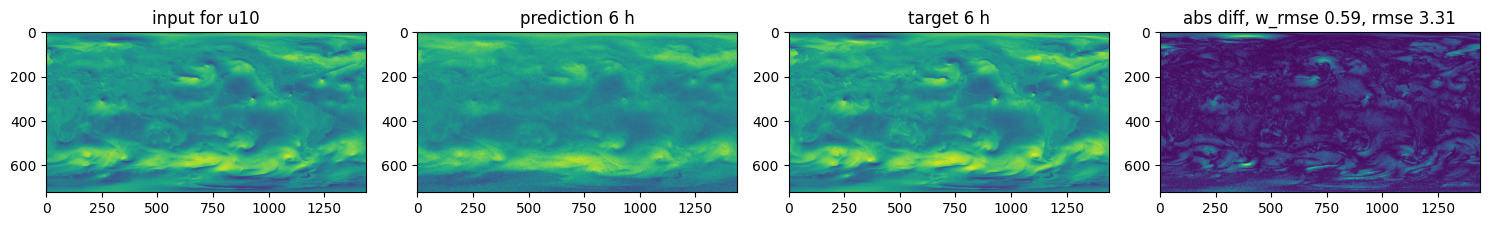

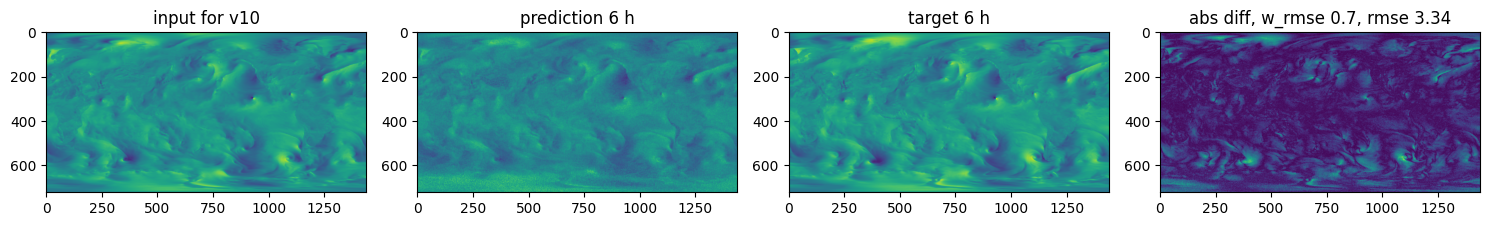

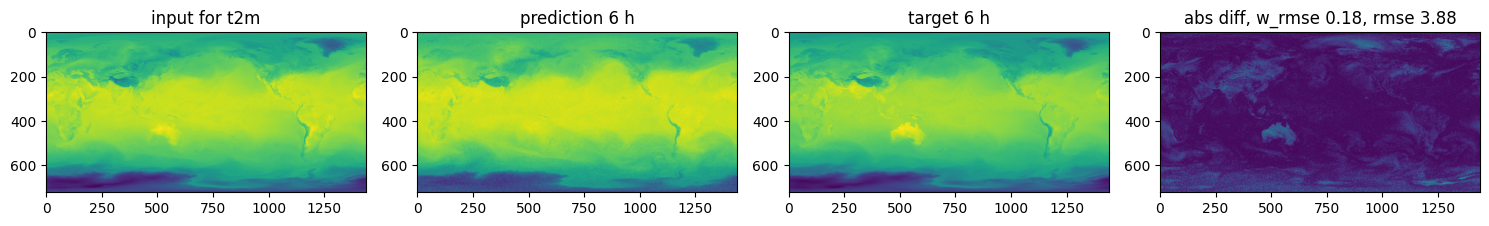

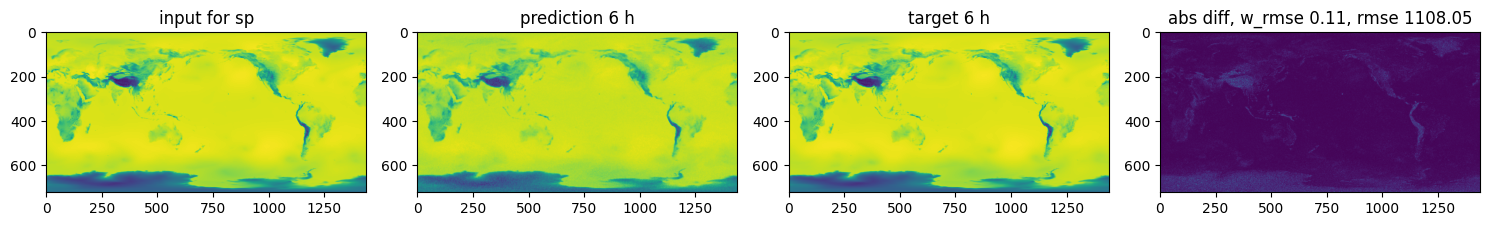

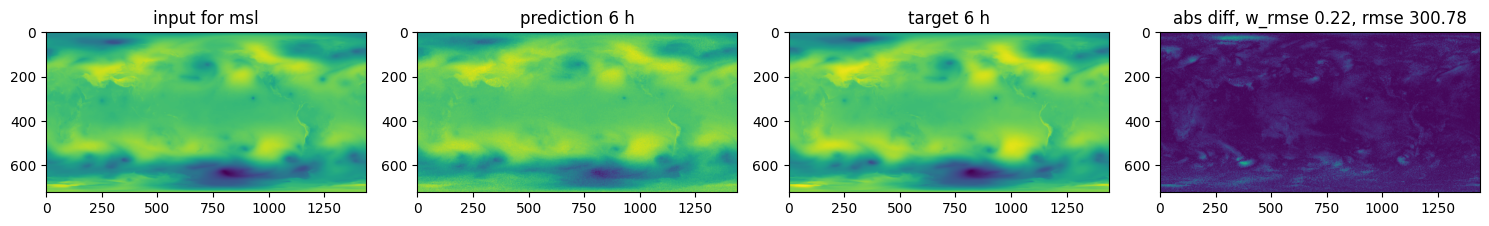

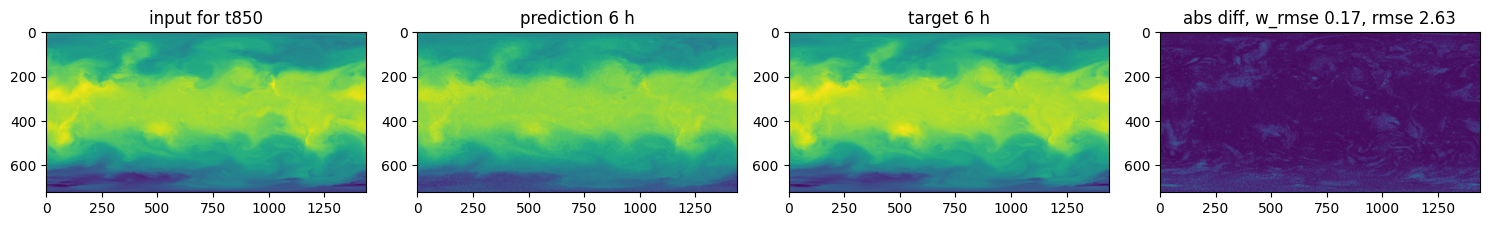

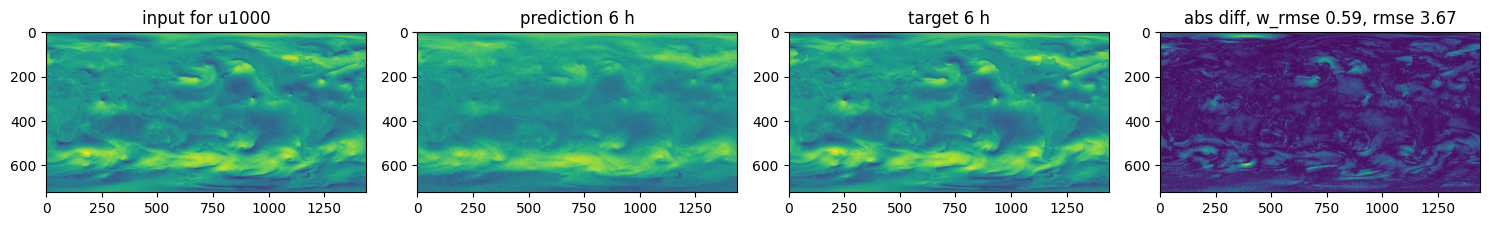

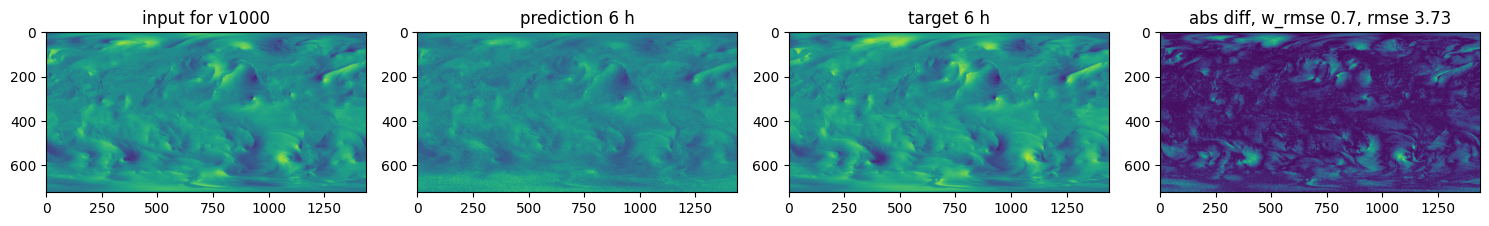

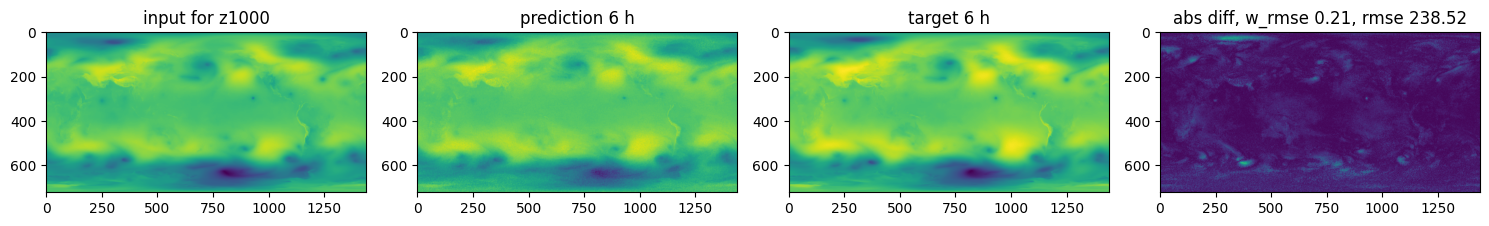

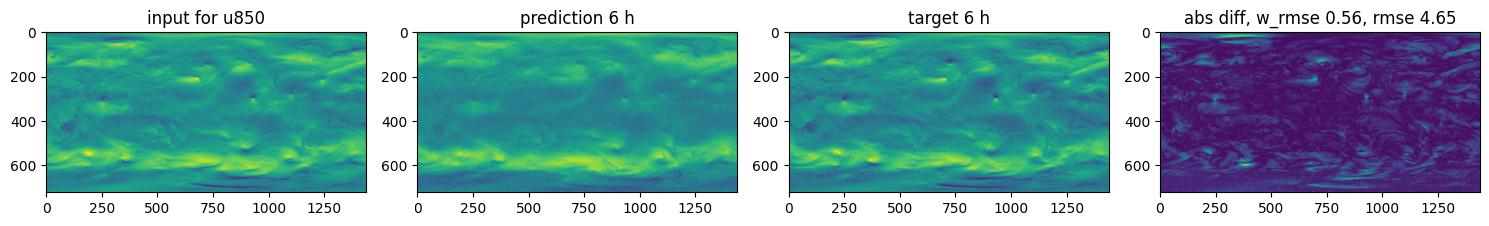

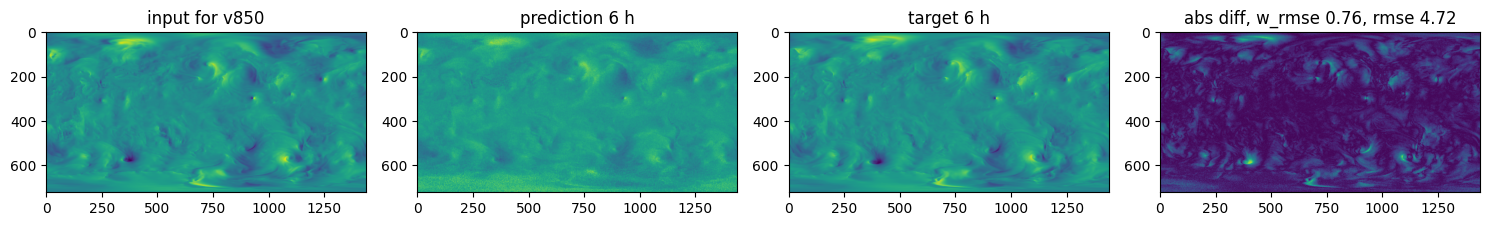

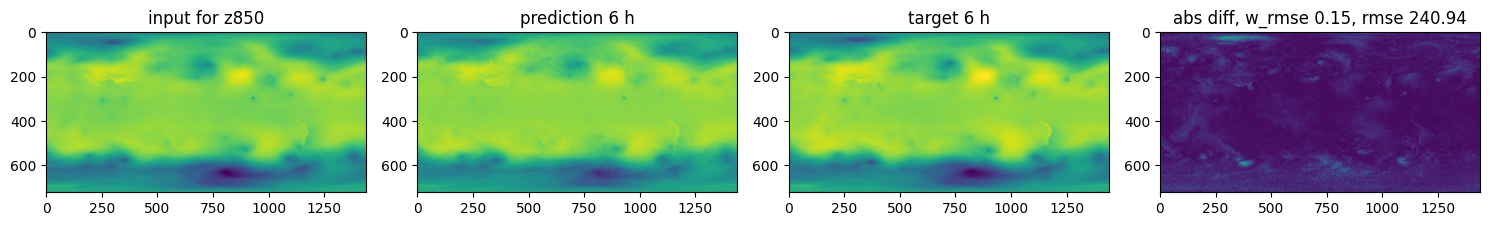

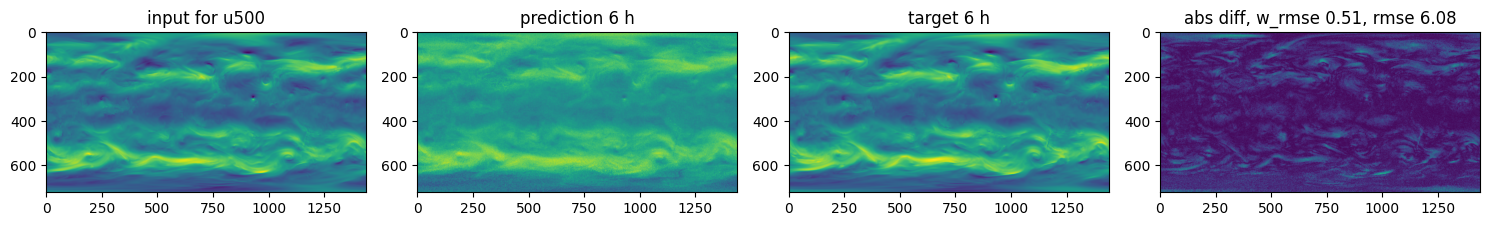

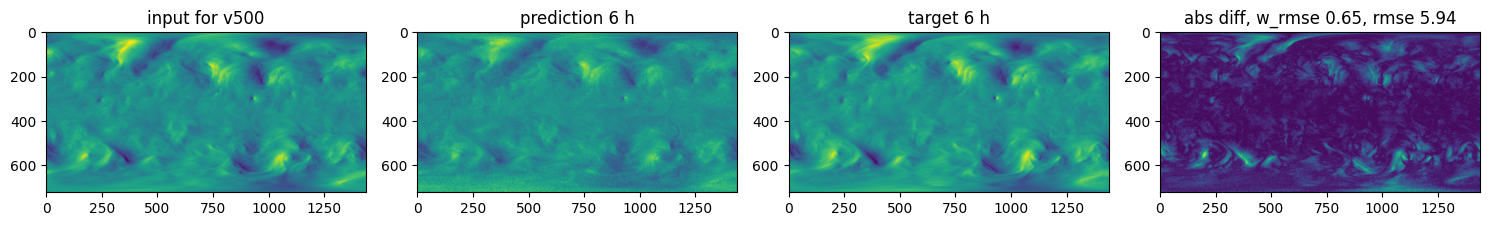

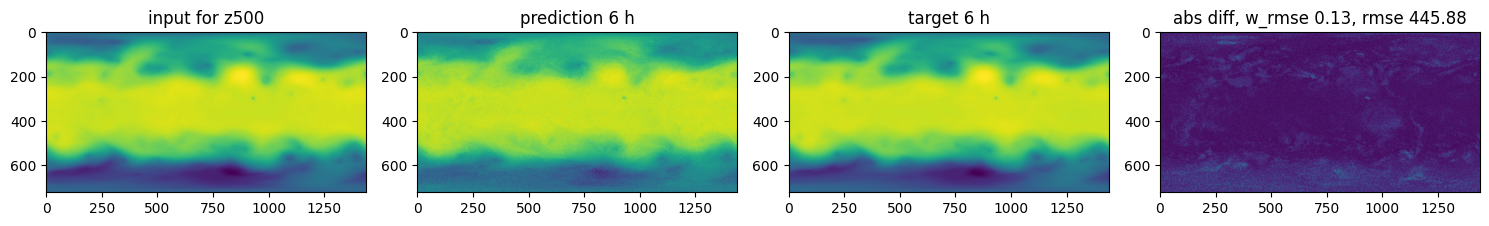

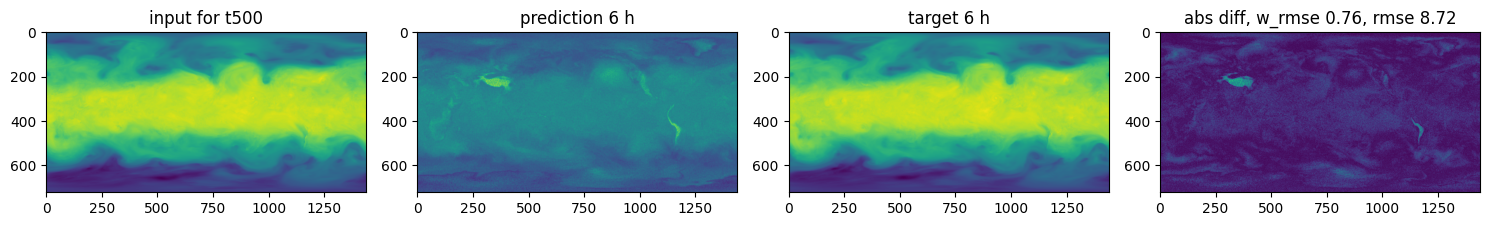

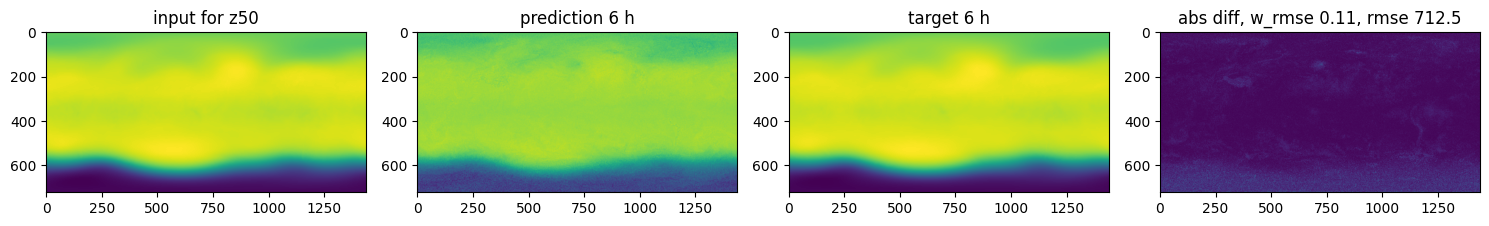

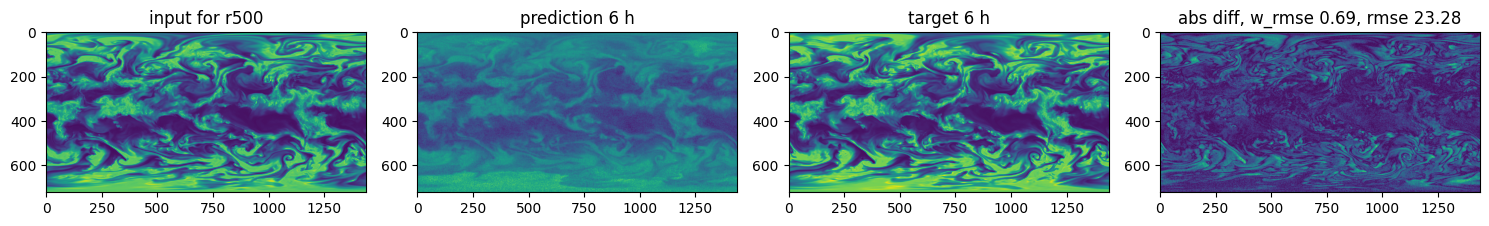

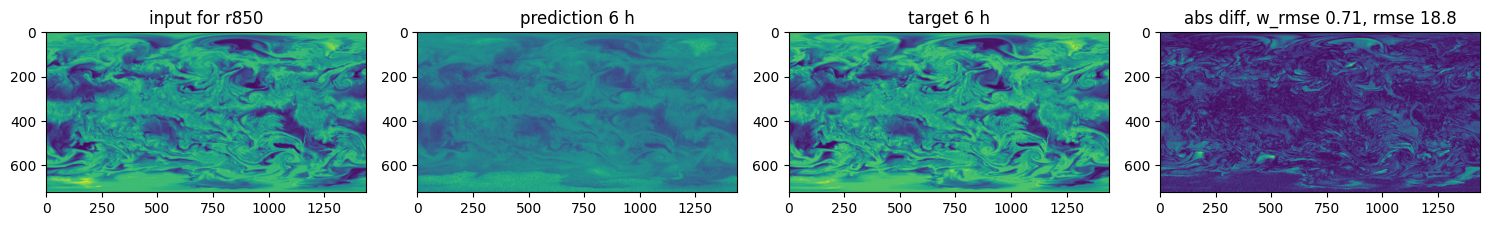

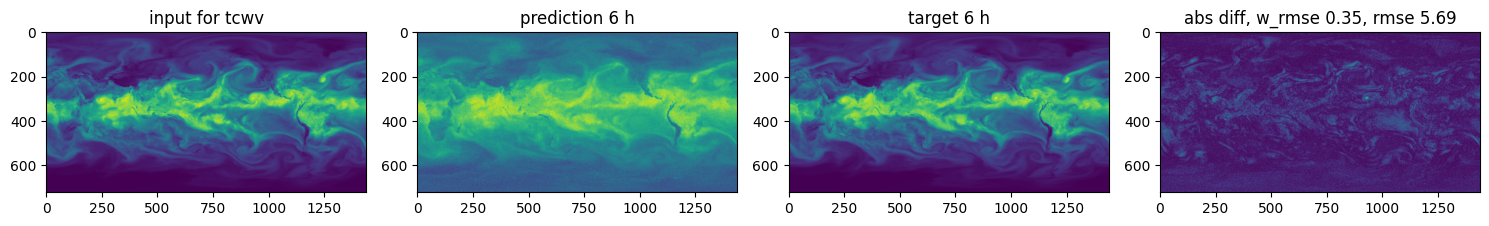

In [12]:
# plot image
import matplotlib.pyplot as plt


def plot_image(inputs, variable = "t2m", log=False):
    idx = VARIABLES.index(variable)
    # x has shape [BATCH_SIZE,  HEIGHT * WIDTH, N_VAR] -> [BATCH_SIZE, HEIGHT, WIDTH, N_VAR]

    for key, value in inputs.items():
        image = value
        image = image.reshape(BATCH_SIZE, HEIGHT, WIDTH, N_VAR)
        image = image[:, :, :, idx]
        image = image.detach().numpy()
        image = image * STDS[idx] + MEANS[idx]
        image = image[0]
        inputs[key] = image



    fig, axs = plt.subplots(1, len(inputs), figsize=(15, 5))
    for i, (key, value) in enumerate(inputs.items()):
        axs[i].imshow(value)
        axs[i].set_title(key)

    plt.tight_layout()
    plt.show()
    


for i , var in enumerate(VARIABLES):
    difference = torch.abs(y_hat - target)
    num = rmse[0][i].item()
    num = round(num, 2)
    num_scaled = rmse_scaled[0][i].item()
    num_scaled = round(num_scaled, 2)

    inputs = {f"input for {var}": x, "prediction 6 h": y_hat, "target 6 h": target, f"abs diff, w_rmse {num}, rmse {num_scaled}": difference}
    plot_image(inputs, var)

